In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import warnings
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.src.layers import Dense
from keras.src.layers import LSTM, Dropout
from keras.src.optimizers import Adam
from keras.src.callbacks import ModelCheckpoint, EarlyStopping
import math
from sklearn.metrics import mean_squared_error
import datetime
import mplfinance as mpf
import math 
import os

In [58]:
df = pd.read_csv('data/historical_data/WUSH_4h.csv')
print(df.head())

df

                        Time    Open    High     Low   Close   Volume
0  2022-12-14 12:00:00+00:00  239.00  258.72  157.00  185.40  2824316
1  2022-12-15 04:00:00+00:00  185.00  188.30  182.64  184.53   211539
2  2022-12-15 08:00:00+00:00  184.19  185.58  183.33  183.57   543649
3  2022-12-15 12:00:00+00:00  183.65  184.26  182.70  182.80   245972
4  2022-12-16 04:00:00+00:00  182.81  183.98  182.80  182.87    44019


,Time,Open,High,Low,Close,Volume
0,2022-12-14 12:00:00+00:00,239.00,258.72,157.00,185.40,2824316
1,2022-12-15 04:00:00+00:00,185.00,188.30,182.64,184.53,211539
2,2022-12-15 08:00:00+00:00,184.19,185.58,183.33,183.57,543649
3,2022-12-15 12:00:00+00:00,183.65,184.26,182.70,182.80,245972
4,2022-12-16 04:00:00+00:00,182.81,183.98,182.80,182.87,44019
...,...,...,...,...,...,...
1185,2024-05-22 16:00:00+00:00,311.43,313.43,310.80,312.46,44386
1186,2024-05-22 20:00:00+00:00,312.45,312.76,312.42,312.55,4497
1187,2024-05-23 04:00:00+00:00,312.55,313.16,308.50,310.30,101886
1188,2024-05-23 08:00:00+00:00,310.29,311.65,309.70,310.70,120817


In [84]:
df['Time']

0      2022-12-14 12:00:00
1      2022-12-15 04:00:00
2      2022-12-15 08:00:00
3      2022-12-15 12:00:00
4      2022-12-16 04:00:00
               ...        
1185   2024-05-22 16:00:00
1186   2024-05-22 20:00:00
1187   2024-05-23 04:00:00
1188   2024-05-23 08:00:00
1189   2024-05-23 12:00:00
Name: Time, Length: 1190, dtype: datetime64[ns]

In [60]:
import datetime

def str_to_datetime(s):
    date_part, time_part = s.split(' ')[0], s.split(' ')[1].split('+')[0]
    
    year, month, day = map(int, date_part.split('-'))
    hour, _, _ = map(int, time_part.split(':'))
    
    return datetime.datetime(year=year, month=month, day=day, hour=hour, minute=0, second=0)


In [61]:
df

,Time,Open,High,Low,Close,Volume
0,2022-12-14 12:00:00+00:00,239.00,258.72,157.00,185.40,2824316
1,2022-12-15 04:00:00+00:00,185.00,188.30,182.64,184.53,211539
2,2022-12-15 08:00:00+00:00,184.19,185.58,183.33,183.57,543649
3,2022-12-15 12:00:00+00:00,183.65,184.26,182.70,182.80,245972
4,2022-12-16 04:00:00+00:00,182.81,183.98,182.80,182.87,44019
...,...,...,...,...,...,...
1185,2024-05-22 16:00:00+00:00,311.43,313.43,310.80,312.46,44386
1186,2024-05-22 20:00:00+00:00,312.45,312.76,312.42,312.55,4497
1187,2024-05-23 04:00:00+00:00,312.55,313.16,308.50,310.30,101886
1188,2024-05-23 08:00:00+00:00,310.29,311.65,309.70,310.70,120817


In [62]:
df['Time'] = df['Time'].apply(str_to_datetime)
df['Time']

0      2022-12-14 12:00:00
1      2022-12-15 04:00:00
2      2022-12-15 08:00:00
3      2022-12-15 12:00:00
4      2022-12-16 04:00:00
               ...        
1185   2024-05-22 16:00:00
1186   2024-05-22 20:00:00
1187   2024-05-23 04:00:00
1188   2024-05-23 08:00:00
1189   2024-05-23 12:00:00
Name: Time, Length: 1190, dtype: datetime64[ns]

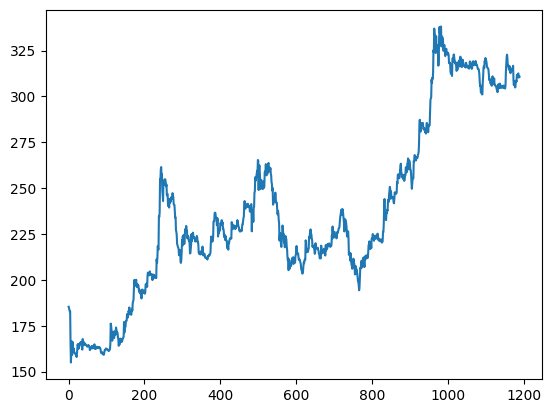

In [63]:
plt.plot(df.index, df['Close'])

In [64]:
def specific_data(start, end):
    data = df
    filtered_data = data[(data['Time'] >= start) & (data['Time'] <= end)]
    return filtered_data

In [65]:
start_time= '2022-12-14 12:00:00'
end_time='2024-05-13 20:00:00'

spec_df = specific_data(start_time, end_time)
spec_df

,Time,Open,High,Low,Close,Volume
0,2022-12-14 12:00:00,239.00,258.72,157.00,185.40,2824316
1,2022-12-15 04:00:00,185.00,188.30,182.64,184.53,211539
2,2022-12-15 08:00:00,184.19,185.58,183.33,183.57,543649
3,2022-12-15 12:00:00,183.65,184.26,182.70,182.80,245972
4,2022-12-16 04:00:00,182.81,183.98,182.80,182.87,44019
...,...,...,...,...,...,...
1147,2024-05-13 04:00:00,304.88,307.61,304.70,305.95,86685
1148,2024-05-13 08:00:00,305.78,306.46,304.52,305.77,141843
1149,2024-05-13 12:00:00,305.69,305.79,304.12,304.85,70859
1150,2024-05-13 16:00:00,304.96,305.43,303.07,304.62,89069


In [66]:
import plotly.express as px
import pandas as pd


fig = px.line(spec_df, x='Time', y='Close', title='Closing Prices Over Time')

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Closing price',
    xaxis=dict(
        tickformat='%Y-%m-%d',
        tickangle=45
    )
)

fig.show()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [67]:
import plotly.graph_objects as go
import pandas as pd

specc_df = specific_data('2024-04-14 12:00:00','2024-05-13 20:00:00')

fig = go.Figure(data=[go.Candlestick(x=specc_df['Time'],
                open=specc_df['Open'],
                high=specc_df['High'],
                low=specc_df['Low'],
                close=specc_df['Close'])])

fig.update_layout(
    title='Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis=dict(tickformat='%Y-%m-%d', tickangle=45),
    template='plotly_white'
)

fig.show()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [68]:
import plotly.graph_objects as go
import pandas as pd

# Проверка данных
print(spec_df.head())

window_hours = 24
spec_df['1-Day Moving Avg'] = spec_df['Close'].rolling(window=window_hours).mean()

fig = go.Figure()

fig.add_trace(go.Scatter(x=spec_df['Time'], y=spec_df['Close'], mode='lines', name='Closing Price', line=dict(width=2)))

fig.add_trace(go.Scatter(x=spec_df['Time'], y=spec_df['1-Day Moving Avg'], mode='lines', name='1-Day Moving Avg', line=dict(dash='dash')))

fig.update_layout(
    title='Closing Prices and 1-Day Moving Average',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis=dict(tickformat='%Y-%m-%d %H:%M:%S', tickangle=45),
    legend=dict(x=0, y=1),
    template='plotly_white'
)

fig.show()


                 Time    Open    High     Low   Close   Volume
0 2022-12-14 12:00:00  239.00  258.72  157.00  185.40  2824316
1 2022-12-15 04:00:00  185.00  188.30  182.64  184.53   211539
2 2022-12-15 08:00:00  184.19  185.58  183.33  183.57   543649
3 2022-12-15 12:00:00  183.65  184.26  182.70  182.80   245972
4 2022-12-16 04:00:00  182.81  183.98  182.80  182.87    44019


/var/folders/f0/zwtts9w11p52b78sr6n20nwc0000gn/T/ipykernel_20965/1560874341.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [69]:
import plotly.express as px
import pandas as pd

spec_df['Time'] = pd.to_datetime(spec_df['Time'])

spec_df['Month'] = spec_df['Time'].dt.month

monthly_average = spec_df.groupby('Month')['Close'].mean().reset_index()

fig = px.line(monthly_average, x='Month', y='Close', markers=True, title='Monthly Seasonality of Closing Prices')

fig.update_layout(
    xaxis_title='Months',
    yaxis_title='Average Closing Price',
    xaxis=dict(tickmode='array', tickvals=list(range(1, 13)), ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']),
    template='plotly_white'
)

fig.show()



/var/folders/f0/zwtts9w11p52b78sr6n20nwc0000gn/T/ipykernel_20965/151879396.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f0/zwtts9w11p52b78sr6n20nwc0000gn/T/ipykernel_20965/151879396.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [70]:
new_df = spec_df.reset_index()['Close']

In [71]:
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [72]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [73]:
n_past = 100

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)


In [74]:
print("Traning set size:-")
print(X_train.shape), print(y_train.shape)
print('\n')
print("Testing set size:-")
print(X_test.shape), print(y_train.shape)

Traning set size:-
(821, 100)
(821,)


Testing set size:-
(131, 100)
(821,)


(None, None)

In [75]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [76]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
checkpoints = ModelCheckpoint(filepath='my_weights.keras', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [77]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,857 (1.26 MB)

 Trainable params: 329,857 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[checkpoints, early_stopping]
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - loss: 0.0335 - val_loss: 0.0026
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - loss: 0.0041 - val_loss: 0.0055
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - loss: 0.0028 - val_loss: 5.5696e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━

In [79]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [80]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [81]:
print(math.sqrt(mean_squared_error(y_train, train_predict)))
print(math.sqrt(mean_squared_error(y_test, test_predict)))

227.88534909656218
311.8981748683905


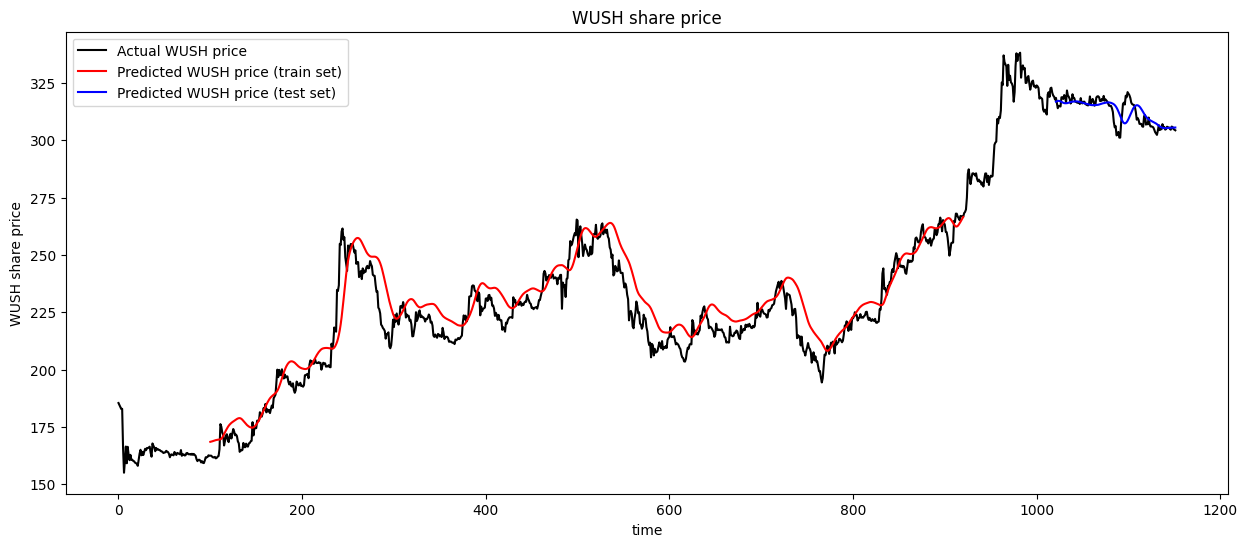

In [82]:
file_name = "WUSH_4h.csv.csv"

company_name = os.path.basename(file_name).split('_')[0]

look_back = 100
trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back] = train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:] = test_predict.flatten()

original_scaled_data = scaler.inverse_transform(scaled_data)

plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {company_name} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {company_name} price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {company_name} price (test set)")
plt.title(f"{company_name} share price")
plt.xlabel("time")
plt.ylabel(f"{company_name} share price")
plt.legend()
plt.show()


In [83]:
import numpy as np

last_sequence = X_test[-1]

last_sequence = last_sequence.reshape(1, look_back, 1)

predictions_next_7_days = []

for _ in range(7):
    daily_predictions = []
    for _ in range(4):
        next_hour_prediction = model.predict(last_sequence)
        daily_predictions.append(next_hour_prediction[0, 0])
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = next_hour_prediction
    predictions_next_7_days.extend(daily_predictions)


predictions_next_7_days = scaler.inverse_transform(np.array(predictions_next_7_days).reshape(-1, 1))

print("Predictions for the next 7 days:")
for i in range(7):
    day_predictions = predictions_next_7_days[i*4:(i+1)*4]
    print(f"Day {i+1}: Predicted Prices = {day_predictions.flatten()}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━